In [1]:
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import urllib.request
import os
from google_patent_scraper import scraper_class
import json
import timeit
import networkx as nx
import matplotlib.pyplot as plt

In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\carlo\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

## Loading patents

In [2]:
ids = pd.read_csv(r"../data/gp-q2-7topics.csv",index_col='code',skipinitialspace=True)
print(ids.isnull().sum())
ids 

Unnamed: 0            0
title                 0
pub_date              0
citations             0
abstract              0
class                 0
year                  0
abstract_processed    0
topic                 0
dtype: int64


,Unnamed: 0,title,pub_date,citations,abstract,class,year,abstract_processed,topic
code,,,,,,,,,
US8370262B2,0,System and method for performing secure online...,2013-02-05,"['US10681025B2', 'CN106664208B', 'AU2012261635...",\nThe system and method performing secure onli...,G06,2013,\nthe system and method performing secure onli...,4
US10237070B2,1,System and method for sharing keys across auth...,2019-03-19,"['US10268809B2', 'JP6538821B2', 'KR101721032B1...","\nA system, apparatus, method, and machine rea...",H04,2019,\na system apparatus method and machine readab...,4
US10637853B2,2,Authentication techniques including speech and...,2020-04-28,"['US10706421B2', 'US20160269411A1', 'US1021258...","\nA system, apparatus, method, and machine rea...",H04,2020,\na system apparatus method and machine readab...,4
US10558974B2,3,Methods and systems of providing verification ...,2020-02-11,"['US20190149537A1', 'US20180308098A1', 'US2018...",\nA method and system of providing verificatio...,G06,2020,\na method and system of providing verificatio...,4
US10769635B2,4,Authentication techniques including speech and...,2020-09-08,"['US9531710B2', 'US10706421B2', 'US20160269411...","\nA system, apparatus, method, and machine rea...",G06,2020,\na system apparatus method and machine readab...,1
...,...,...,...,...,...,...,...,...,...
KR100477956B1,9471,System and method for filtering message edited...,2005-03-23,"['US9501746B2', 'US10110519B2', 'US7133898B1',...",\r\nA method and system for filtering a messag...,H04,2005,\r\na method and system for filtering a messag...,6
FR3092468A1,9472,Secure registration and building control system,2020-08-07,"['US20150173255A1', 'US10147307B2', 'US9135807...",\r\n \r\n \r\n [Systme denregis...,H04,2020,\r\n \r\n \r\n [systme denregis...,0
CN105723378B,9473,Protection system including safety regulation ...,2019-06-18,"['JP2017034696A', 'CN107852410B', 'CN105210042...",\nThis disclosure relates to a kind of protect...,H04,2019,\nthis disclosure relates to a kind of protect...,3


ids = ids[ids.abstract.notna()]
#ids = ids[ids['class'].notna()]
ids = ids[ids['citations']!='[]']
ids['class'] = ids['class'].astype('str').apply(lambda x: x[:4] if len(x) >= 3 else 'NAN')
print(ids.isnull().sum())


In [3]:
ids['class'] = [cl if cl=='G06' or cl=='H04' else 'other' for cl in ids['class']  ]
ids['class'].value_counts()

G06      4726
H04      3304
other    1446
Name: class, dtype: int64

In [4]:
ids['class_topic'] = [ cl + '_' + str(topic) for (cl,topic) in ids[['class','topic']].values]
pd.crosstab(ids['class'],ids['topic'])

topic,0,1,2,3,4,5,6
class,,,,,,,
G06,696,480,391,770,897,958,534
H04,406,249,252,293,689,1107,308
other,119,99,146,700,88,227,67


## Building the network

In [5]:
G = nx.Graph()

for code, patent in ids.iterrows():
    patent['class_topic'] = patent['class'] + '_' + str(patent['topic'])
    if patent['citations'] != '[]': #citation is a string represetnation of a list 
        for l in str(patent['citations'][1:-1]).split(','):
            link = l.replace(" ","")[1:-1]
            if link in ids.index and link!=code: 
                G.add_edge(code, str(link) )

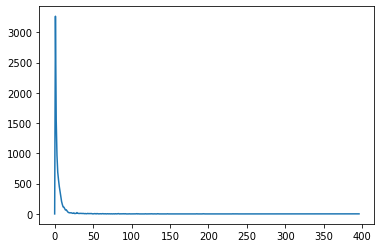

density:  0.0006411086026523331
average clustering coefficient:  0.10546879732181237


In [6]:
plt.plot(nx.degree_histogram(G))
plt.show()
print('density: ', nx.density(G))
print('average clustering coefficient: ', nx.average_clustering(G))

In [7]:
ids['class']=ids['class'].astype('str')

nx.set_node_attributes(G, 'NA', name='class')
for node in ids.index:
    nx.set_node_attributes(G, {node: str(ids.loc[node,'class'])}, name='class')
    nx.set_node_attributes(G, {node: str(ids.loc[node,'topic'])}, name='topic')
    nx.set_node_attributes(G, {node: str(ids.loc[node,'class_topic'])}, name='class_topic')
                           
print('number of nodes: ', len(G.nodes))
pd.Series( [G.nodes[node]['class_topic'] for node in G.nodes]).value_counts()

number of nodes:  9476


H04_5      1107
G06_5       958
G06_4       897
G06_3       770
other_3     700
G06_0       696
H04_4       689
G06_6       534
G06_1       480
H04_0       406
G06_2       391
H04_6       308
H04_3       293
H04_2       252
H04_1       249
other_5     227
other_2     146
other_0     119
other_1      99
other_4      88
other_6      67
dtype: int64

In [8]:
nx.write_graphml(G, "../data/7topics.graphml")

# Components

In [9]:
G = nx.read_graphml("../data/7topics.graphml") #when reading you should change the attibute names
components =  [c for c in sorted(nx.connected_components(G), key=len, reverse=True)]
avg_size = np.average([len(c) for c in components])
print('average componets size: ', avg_size)
print([len(c) for c in components[:7]])

average componets size:  24.359897172236504
[8104, 120, 68, 45, 22, 18, 17]


In [10]:
Large = components[0]
L = G.subgraph(Large)
nx.write_graphml(L, "../data/LargeComp7topics.graphml")

mediums = [c for c in components[1:] if len(c) >= avg_size]
ms = G.subgraph([node  for c in mediums for node in c])
nx.write_graphml(ms, "../data/mediumComps7topics.graphml")

smalls = [c for c in components[1:] if len(c) < avg_size]
ss = G.subgraph([node  for c in smalls for node in c])
nx.write_graphml(ss, "../data/smallmComps7topics.graphml")

print(len(Large),nx.average_clustering(G,Large))
for c in mediums: print(len(c),nx.average_clustering(G,c))

8104 0.1136870783151341
120 0.5639412318862846
68 0.020647653000594176
45 0.0


In [11]:
len(components)

389

In [23]:
for c in mediums:
    print('\n\n')
    for node in c:
        print(ids.loc[node,'title'])




Provision of content to mobile communication facilities based on contextual data and behavior data related to a part of mobile content 
Contextual mobile content placement on a mobile communication facility 
Mobile dynamic advertisement creation and placement 
Contextual mobile content placement on a mobile communication facility 
Integrating subscription content into mobile search results 
Methods and systems for mobile coupon tracking 
Mobile pay per call 
Mobile search services related to direct identifiers 
Mobile dynamic advertisement creation and placement 
Mobile comparison shopping 
System for retrieving mobile communication facility user data from a plurality of providers 
Managing sponsored content based on transaction history 
Mobile dynamic advertisement creation and placement 
Mobile User Profile Creation based on User Browse Behaviors 
Search query address redirection on a mobile communication facility 
User transaction history influenced search results 
Presentation o

In [20]:
import spacy
from spacy.lang.en import English 
stopwords = spacy.lang.en.stop_words.STOP_WORDS
for c in mediums:
    print('\n')
    titles = [[w.lower() for w in title.split(' ') if w not in stopwords] for title in ids.loc[c,'title']]
    titles = [w  for title in titles for w in title]
    print(pd.Series(titles).value_counts())



                 120
mobile           102
content           51
communication     33
search            25
                ... 
on-off             1
fraud              1
interaction        1
sponsor            1
transcoded         1
Length: 181, dtype: int64


             68
content      22
system       17
video        16
media        15
             ..
assets        1
treatment     1
time          1
equipment     1
behavior      1
Length: 228, dtype: int64


               45
methods        13
data           11
digital         8
signals         8
               ..
materials       1
cards           1
portions        1
viewable        1
application     1
Length: 139, dtype: int64


We analyse titles of medium size components to find something intersting.
But we eill focus on the unique large component found.
# Large component

In [24]:
L = nx.read_graphml( "../data/LargeComp7topics.graphml")
print(len(G))
print(len(L))

9476
8104


# CORES

In [25]:
G = L.copy()
cores = nx.core_number(G)
print(pd.Series(cores).value_counts())
for node in G.nodes:
     nx.set_node_attributes(G, {node: cores[node]}, name='core')
nx.write_graphml(G, "../data/L_cores.graphml")

1     2589
2     1587
3      918
4      708
5      573
6      480
8      407
7      321
9      138
11      89
10      77
13      63
12      53
14      51
15      50
dtype: int64


In [26]:
ids['core'] = [0 for patent in ids.index]
for patent in cores.keys():
    ids.loc[patent,'core'] = cores[node]
    

## Community detection 

Louvain is is not to computationally expensive and we can use it on the entire net.

In [45]:
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx



# compute the best partition
partition = community_louvain.best_partition(G)
nx.set_node_attributes(G,{node: partition[node] for node in partition},'louvain')

In [46]:
for node in G.nodes:
    ids.loc[node,'louvain'] = G.nodes[node]['louvain']

ids.to_csv('../data/gp-q2-7topics-louvain.csv')
nx.write_graphml(G,'../data/louvain.graphml')

In [47]:
ids.louvain.value_counts()

2.0     1604
5.0      881
10.0     803
0.0      729
9.0      640
8.0      513
14.0     455
1.0      434
11.0     353
15.0     326
3.0      281
12.0     208
16.0     195
4.0      175
13.0     106
7.0       92
6.0       78
21.0      60
25.0      58
18.0      56
23.0      10
19.0       8
24.0       8
27.0       7
26.0       7
20.0       7
17.0       6
22.0       4
Name: louvain, dtype: int64

In [68]:
partitions = [[node for node in partition if partition[node] == part] for part in list(pd.Series([key for key in partition.values()]).unique())]
partitions =  [c for c in sorted(partitions, key=len, reverse=True)]

In [82]:
df = ids.loc[ids.index.isin(G.nodes)]

In [87]:
df.loc['US8370262B2','topic'] ==4

True

### Community Cores

In [50]:
ids = pd.read_csv('../data/gp-q2-7topics-louvain.csv', index_col='code')
G=nx.read_graphml('../data/louvain.graphml')
print(len(G))
print(len(ids))
ids.isnull().sum()

8104
9476


Unnamed: 0               0
title                    0
pub_date                 0
citations                0
abstract                 0
class                    0
year                     0
abstract_processed       0
topic                    0
class_topic              0
core                     0
louvain               1372
dtype: int64

In [51]:
print('average length is ',np.average(ids.louvain.value_counts()))
ids.louvain.value_counts()

average length is  289.42857142857144


2.0     1604
5.0      881
10.0     803
0.0      729
9.0      640
8.0      513
14.0     455
1.0      434
11.0     353
15.0     326
3.0      281
12.0     208
16.0     195
4.0      175
13.0     106
7.0       92
6.0       78
21.0      60
25.0      58
18.0      56
23.0      10
19.0       8
24.0       8
27.0       7
26.0       7
20.0       7
17.0       6
22.0       4
Name: louvain, dtype: int64

In [52]:
ids = ids[ids.louvain.notna()]

In [53]:
for community in ids['louvain'].astype(int).unique() :
    globals()['LC'+str(community)] = G.subgraph([node for node in G.nodes if G.nodes[node]['louvain']==community])
LCs = [globals()['LC'+str(community)] for community in ids['louvain'].astype(int).unique() ]
LCs = [G.subgraph([node for node in G.nodes if G.nodes[node]['louvain']==community]) for community in ids['louvain'].astype(int).unique()]

In [54]:
for LC in LCs:
    LCcores = nx.core_number(LC)
    for node in LC.nodes:
        nx.set_node_attributes(LC, {node: LCcores[node]}, name='LCcore')
        nx.set_node_attributes(G,{node:LCcores[node]},'LCcore')
        ids.loc[node,'LCcore'] = LCcores[node]


In [55]:
ids

,Unnamed: 0,title,pub_date,citations,abstract,class,year,abstract_processed,topic,class_topic,core,louvain,LCcore
code,,,,,,,,,,,,,
US8370262B2,0,System and method for performing secure online...,2013-02-05,"['US10681025B2', 'CN106664208B', 'AU2012261635...",\nThe system and method performing secure onli...,G06,2013,\nthe system and method performing secure onli...,4,G06_4,2,0.0,4.0
US10237070B2,1,System and method for sharing keys across auth...,2019-03-19,"['US10268809B2', 'JP6538821B2', 'KR101721032B1...","\nA system, apparatus, method, and machine rea...",H04,2019,\na system apparatus method and machine readab...,4,H04_4,2,0.0,6.0
US10637853B2,2,Authentication techniques including speech and...,2020-04-28,"['US10706421B2', 'US20160269411A1', 'US1021258...","\nA system, apparatus, method, and machine rea...",H04,2020,\na system apparatus method and machine readab...,4,H04_4,2,0.0,6.0
US10558974B2,3,Methods and systems of providing verification ...,2020-02-11,"['US20190149537A1', 'US20180308098A1', 'US2018...",\nA method and system of providing verificatio...,G06,2020,\na method and system of providing verificatio...,4,G06_4,2,1.0,3.0
US10769635B2,4,Authentication techniques including speech and...,2020-09-08,"['US9531710B2', 'US10706421B2', 'US20160269411...","\nA system, apparatus, method, and machine rea...",G06,2020,\na system apparatus method and machine readab...,1,G06_1,2,0.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
KR100477956B1,9471,System and method for filtering message edited...,2005-03-23,"['US9501746B2', 'US10110519B2', 'US7133898B1',...",\r\nA method and system for filtering a messag...,H04,2005,\r\na method and system for filtering a messag...,6,H04_6,2,2.0,2.0
FR3092468A1,9472,Secure registration and building control system,2020-08-07,"['US20150173255A1', 'US10147307B2', 'US9135807...",\r\n \r\n \r\n [Systme denregis...,H04,2020,\r\n \r\n \r\n [systme denregis...,0,H04_0,2,11.0,1.0
CN105723378B,9473,Protection system including safety regulation ...,2019-06-18,"['JP2017034696A', 'CN107852410B', 'CN105210042...",\nThis disclosure relates to a kind of protect...,H04,2019,\nthis disclosure relates to a kind of protect...,3,H04_3,2,11.0,1.0


In [56]:
louvains_top = []
for lc in ids['louvain'].astype(int).unique():
    d = ids[ids.louvain==lc]
    m= max(d.LCcore)
    print(m)
    louvains_top.append(d[d.LCcore==m]) 

8.0
6.0
7.0
4.0
2.0
5.0
2.0
15.0
3.0
3.0
10.0
4.0
8.0
4.0
6.0
2.0
2.0
5.0
1.0
3.0
1.0
1.0
1.0
2.0
1.0
1.0
1.0
1.0


In [58]:
top_patents =louvains_top[0]
for top in louvains_top[1:]:
    top_patents = top_patents.append(top)
print(len(top_patents))
top_patents.head()

668


,Unnamed: 0,title,pub_date,citations,abstract,class,year,abstract_processed,topic,class_topic,core,louvain,LCcore
code,,,,,,,,,,,,,
EP3410328A1,29,Method and system to distinguish between a hum...,2018-12-05,"['US9531710B2', 'US10032010B2', 'US10083304B2'...",\nA system and method to distinguish between a...,G06,2018,\na system and method to distinguish between a...,0,G06_0,2,0.0,8.0
US10032010B2,30,"System, device, and method of visual login and...",2018-07-24,"['US9071969B2', 'US10839065B2', 'US20190364019...","\nDevices, systems, and methods of detecting u...",G06,2018,\ndevices systems and methods of detecting use...,1,G06_1,2,0.0,8.0
US9547766B2,31,"Device, system, and method of detecting malici...",2017-01-17,"['US10230718B2', 'US10049209B2', 'US9071969B2'...","\nDevices, systems, and methods of detecting u...",G06,2017,\ndevices systems and methods of detecting use...,1,G06_1,2,0.0,8.0
US10740758B2,32,"Context-dependent authentication system, metho...",2020-08-11,"['US9531710B2', 'US10164985B2', 'US10002244B2'...",\nA method for authenticating a user using a u...,G06,2020,\na method for authenticating a user using a u...,6,G06_6,2,0.0,8.0
US10055560B2,35,"Device, method, and system of detecting multip...",2018-08-21,"['US10230718B2', 'US10049209B2', 'US9071969B2'...","\nDevices, systems, and methods of detecting u...",G06,2018,\ndevices systems and methods of detecting use...,1,G06_1,2,0.0,8.0


In [59]:
top_patents.to_csv('../data/bestPatentsPeLouvain.csv')

# Topic analysis
### Louvain communities

In [50]:
communities

[]

In [102]:
GT0 = G.subgraph([node for node in G.nodes if G.nodes[node]['topic']=='0'])
GT1 = G.subgraph([node for node in G.nodes if G.nodes[node]['topic']=='1'])
GT2 = G.subgraph([node for node in G.nodes if G.nodes[node]['topic']=='2'])
GT3 = G.subgraph([node for node in G.nodes if G.nodes[node]['topic']=='3'])
GT4 = G.subgraph([node for node in G.nodes if G.nodes[node]['topic']=='4'])
GT5 = G.subgraph([node for node in G.nodes if G.nodes[node]['topic']=='5'])
GT6 = G.subgraph([node for node in G.nodes if G.nodes[node]['topic']=='6'])

GTs = [GT0,GT1,GT2,GT3,GT4,GT5,GT6]   
for i in GTs:print(len(i))

1173
555
657
1287
1587
2066
779


for each subgraph, make louvain 

In [95]:
for GT in GTs:
    GTpartition = community_louvain.best_partition(GT)
    nx.set_node_attributes(GT,{node: GTpartition[node] for node in GTpartition},'GTlouvain')


5    2066
4    1587
3    1287
0    1173
6     779
2     657
1     555
Name: topic, dtype: int64

In [104]:
for GT in GTs:
    GTpartition = community_louvain.best_partition(GT)
    nx.set_node_attributes(G,{node: GTpartition[node] for node in GTpartition},'GTlouvain')


In [105]:
for node in G.nodes:
    ids.loc[node,'topiclouvain'] = G.nodes[node]['GTlouvain']

ids.to_csv('../data/gp-q2-GTlouvain.csv')

In [108]:
for t in range(7):
    print('\n\n')
    print(ids[ids.topic==t]['topiclouvain'].value_counts())




5.0      158
8.0       85
6.0       68
72.0      68
95.0      63
        ... 
65.0       1
171.0      1
127.0      1
115.0      1
294.0      1
Name: topiclouvain, Length: 433, dtype: int64



1.0      51
21.0     29
38.0     22
28.0     20
12.0     19
         ..
46.0      1
127.0     1
146.0     1
142.0     1
52.0      1
Name: topiclouvain, Length: 294, dtype: int64



0.0      48
14.0     37
3.0      37
16.0     27
48.0     23
         ..
303.0     1
353.0     1
207.0     1
275.0     1
166.0     1
Name: topiclouvain, Length: 362, dtype: int64



78.0     33
2.0      31
55.0     29
249.0    27
88.0     18
         ..
673.0     1
543.0     1
177.0     1
933.0     1
774.0     1
Name: topiclouvain, Length: 937, dtype: int64



0.0      261
4.0      179
46.0     149
7.0      146
8.0      110
        ... 
149.0      1
340.0      1
93.0       1
422.0      1
217.0      1
Name: topiclouvain, Length: 476, dtype: int64



4.0      205
0.0      143
21.0     138
29.0     112
2.0      110
     

### TOPIC CORES

In [112]:
for GT in GTs:
    GTcores = nx.core_number(GT)
    for node in GT.nodes:
        nx.set_node_attributes(GT, {node: GTcores[node]}, name='GTcore')
        nx.set_node_attributes(G,{node:GTcores[node]},'GTcore')



In [113]:
for node in G.nodes:
    ids.loc[node,'GTcore'] = G.nodes[node]['GTcore']

ids.to_csv('../data/gp-q2-7topics-cores.csv')
nx.write_graphml(G,'../data/7topicsCores.graphml')

In [118]:
topics_top = []
for t in range(7):
    d = ids[ids.topic==t]
    m= max(d.GTcore)
    topics_top.append(d[d.GTcore==m]) 

In [126]:
top_patents =topics_top[0]
for top in topics_top[1:]:
    top_patents = top_patents.append(top)
print(len(top_patents))
top_patents.head()

430


,Unnamed: 0,title,pub_date,citations,abstract,class,year,abstract_processed,topic,class_topic,core,louvain,topiclouvain,GTcore
code,,,,,,,,,,,,,,
JP6239807B1,41,Method and system for behavior analysis of mob...,2017-11-29,"['KR101720930B1', 'CN106575327B', 'US9747430B2...",\n\n The computing device processor identifies...,G06,2017,\n\n the computing device processor identifies...,0,G06_0,2,5.0,5.0,5.0
US10104107B2,162,Methods and systems for behavior-specific actu...,2018-10-16,"['JP6140808B2', 'JP6188956B2', 'US9596257B2', ...",\nVarious embodiments include methods of evalu...,G06,2018,\nvarious embodiments include methods of evalu...,0,G06_0,2,5.0,5.0,5.0
US9910984B2,164,Methods and systems for on-device high-granula...,2018-03-06,"['US9779236B2', 'KR102160659B1', 'EP2836955B1'...",\nVarious aspects include methods and computin...,G06,2018,\nvarious aspects include methods and computin...,0,G06_0,2,5.0,5.0,5.0
US9330257B2,183,Adaptive observation of behavioral features on...,2016-05-03,"['US10015178B2', 'US10397262B2', 'TWI606360B',...","\nMethods, devices and systems for detecting s...",G06,2016,\nmethods devices and systems for detecting su...,0,G06_0,2,5.0,5.0,5.0
US9158604B1,184,Lightweight data-flow tracker for realtime beh...,2015-10-13,"['JP6235000B2', 'US20180300484A1', 'US20140201...",\nMethods and devices for detecting performanc...,G06,2015,\nmethods and devices for detecting performanc...,0,G06_0,2,5.0,5.0,5.0


In [127]:
top_patents.to_csv('../data/bestPatentsPeTopic.csv')

In [110]:
Our research links artificial intelligence with its applications in defence scope.
Methodologies have been developed in order to answer also the assets plus challenge promoted by EU, for which we have been selected..

The analysis starts with a web crawling and scraping on scopus to collect  scientific articles and google patents for the patents found through our query. After that we did text cleaning on the topic modeling on the abstracts collected in the previous phase and applied a network analysis for each of the most interesting topics in order to understand the key technology. Finally to restrict even more our field of research we did a trend analysis in order to find possible gap between research and actual technologies.


SyntaxError: invalid syntax (<ipython-input-110-da4f9e993438>, line 1)

In [94]:
for net in SGts:print(len(net))

779


In [31]:
SG = G.subgraph([node for node in G.nodes if G.nodes[node]['core']>=7 ] )
print(len(SG))

1249


In [44]:
communities =  [c for c in sorted(nx.community.girvan_newman(SG), key=len, reverse=True)]

In [49]:
import timeit
start = timeit.default_timer()  
communities =  [c for c in sorted(nx.community.k_clique_communities(SG,10), key=len, reverse=True)]
   
stop = timeit.default_timer()    
print('Time: ', stop - start) 

Time:  0.2934261999998853


In [47]:
print([len(c) for c in communities])

[101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2]


In [54]:
print([[len(i) for i in c] for c in communities[-4]])

[[12, 12, 11, 11, 12, 11, 11, 11, 15, 11, 12, 12, 12, 11, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 12, 11, 12, 11, 11, 11, 11, 11, 12, 12, 12, 11, 12, 11, 15, 12, 12, 11, 11, 11, 12, 11, 11, 12, 11, 11, 11, 11, 11, 11, 11, 11, 12, 11, 12, 11, 11, 11, 12, 11, 12, 11, 12, 12, 11, 11, 11, 11, 12, 12, 11, 11, 12, 11, 11, 12, 11, 11, 15, 12, 11, 12, 12, 11, 11, 12, 12, 12, 12, 11, 11, 12, 12], [11], [11], [11], [12]]


In [ ]:
# COMMUNITIES ANALYSIS